## L2正则和丢弃法
---

### L2范数惩罚

In [3]:
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append('..')
import d2lzh_pytorch as d2l

n_train, n_test , num_input = 20, 100, 200
true_w, true_b = torch.ones(num_input, 1) * 0.01, 0.05
true_w[:10]

tensor([[0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100]])

In [12]:
features = torch.randn((n_train + n_test, num_input))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)

torch.Size([20, 200])
torch.Size([100, 200])
torch.Size([20, 1])
torch.Size([100, 1])


In [13]:
# [初始化模型参数]
def init_params():
    w = torch.randn((num_input, 1),requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [14]:
# [L2范数惩罚]
def l2_penalty(w):
    return (w**2).sum() / 2

In [19]:
# [定义训练和测试]
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()

            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w,b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w: ', w.norm().item())

L2 norm of w:  12.721118927001953


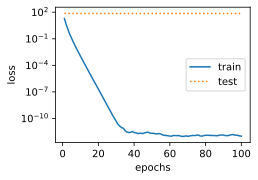

In [20]:
# 没有使用权重衰减
fit_and_plot(lambd=0)

L2 norm of w:  0.04391467571258545


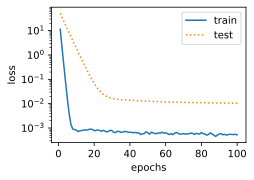

In [26]:
# 使用权重衰减
fit_and_plot(lambd=3)

L2 norm of w:  0.017819780856370926


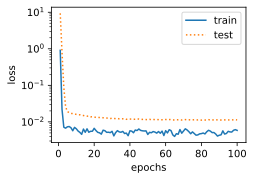

In [25]:
fit_and_plot(lambd=20)

### 调库实现L2

In [30]:
def fit_and_plot_pytorch(wd):
    net = nn.Linear(num_input, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd) # 对权重的衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr) # 不对偏差参数衰减

    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()

            l.backward()

            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w: ', net.weight.data.norm().item())

L2 norm of w:  12.826565742492676


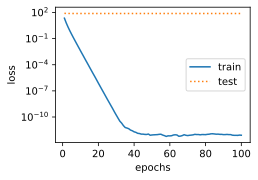

In [31]:
fit_and_plot_pytorch(0)

L2 norm of w:  0.06084102764725685


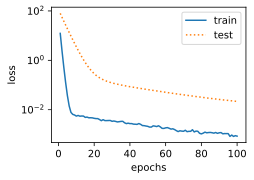

In [32]:
fit_and_plot_pytorch(3)

### 丢弃发

In [5]:
def dropout(X, drop_prob):
    X = X.float()
    assert 0 <= drop_prob <= 1
    keep_prob = 1- drop_prob
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape) < keep_prob).float()

    return mask * X / keep_prob

In [6]:
X = torch.arange(16).view(2, 8)
dropout(X, 0)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

In [7]:
dropout(X, 0.5)

tensor([[ 0.,  2.,  0.,  6.,  0., 10., 12.,  0.],
        [16., 18., 20., 22.,  0., 26., 28.,  0.]])

In [9]:
dropout(X, 1.0)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [10]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_outputs)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)

params = [W1, b1, W2, b2, W3, b3]

In [11]:
drop_prob1, drop_prob2 = 0.2, 0.5

def net(X, is_training=True):
    X = X.view(-1, num_inputs)
    H1 = (torch.matmul(X, W1) + b1).relu()
    if is_training: # 只在训练模型时使用丢弃法
        H1 = dropout(H1, drop_prob1) # 在第一层全连接后添加丢弃层
    H2 = (torch.matmul(H1, W2) + b2).relu()
    if is_training:
        H2 = dropout(H2, drop_prob2) # 在第二层全连接后添加丢弃层
    return torch.matmul(H2,W3) + b3

In [12]:
num_epochs, lr, batch_size = 5, 100.0, 256
loss = torch.nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

d:\anaconda3\envs\pytorch_gpu_1\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


epoch 1, loss 0.0047, train acc 0.525, test acc 0.741
epoch 2, loss 0.0023, train acc 0.781, test acc 0.743
epoch 3, loss 0.0019, train acc 0.822, test acc 0.802
epoch 4, loss 0.0018, train acc 0.838, test acc 0.829
epoch 5, loss 0.0017, train acc 0.846, test acc 0.819


### 简洁实现Dropout

In [13]:
net = nn.Sequential(
    d2l.FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens1),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(num_hiddens1, num_hiddens2),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(num_hiddens2, 10)
)

for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.1)

In [14]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0038, train acc 0.653, test acc 0.750
epoch 2, loss 0.0025, train acc 0.769, test acc 0.809
epoch 3, loss 0.0022, train acc 0.793, test acc 0.829
epoch 4, loss 0.0021, train acc 0.807, test acc 0.823
epoch 5, loss 0.0020, train acc 0.818, test acc 0.837
